# GuideMe - Model Training for Place Prediction
## Using CNN and ResNet50

We are trying to do a model training from the dataset that we have created using CNN and ResNet50. after we do both, we will see an evaluation of the results of the model we have trained and will make a comparison which one is better to use. After determining which model is better, we deploy the model into HDF5 format.

### Datasets

https://drive.google.com/file/d/1n2RWoStVB_KFHolCotztQxdYR9UhPx37/view?usp=sharing



### 1. Import Dataset & Extract 

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
local_zip = '/content/drive/MyDrive/GuideMeAI/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/place-dataset/')
zip_ref.close()

In [3]:
base_dir = '/content/place-dataset/Dataset'

### 2. Checking Dataset

In [4]:
labels = {}
total_images = 0
for i in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, i)))
    labels[i] = count
    total_images += count

print(os.listdir(base_dir))
print("Total images : " + str(total_images))

['monas', 'prambanan']
Total images : 600


### 3. Define constant

In [5]:
IMAGE_SIZE = (416, 416)
BATCH_SIZE = 64
EPOCHS = 20
SEED = 999

FIG_SIZE = (5,2)

### 4. Split dataset

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [7]:
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


### 5. Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

### 6. Training Model Using CNN

#### 6.1. Create Model, Compile, and Training

---



In [9]:
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [10]:
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [11]:
cnn_hist = cnn_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data = valid_data
)

Epoch 1/20
8/8 [==============================] - 25s 1s/step - loss: 0.7945 - accuracy: 0.5437 - val_loss: 0.6817 - val_accuracy: 0.6833
Epoch 2/20
8/8 [==============================] - 7s 800ms/step - loss: 0.6461 - accuracy: 0.7042 - val_loss: 0.6145 - val_accuracy: 0.6500
Epoch 3/20
8/8 [==============================] - 6s 794ms/step - loss: 0.4669 - accuracy: 0.8167 - val_loss: 0.5131 - val_accuracy: 0.7917
Epoch 4/20
8/8 [==============================] - 7s 802ms/step - loss: 0.3759 - accuracy: 0.8396 - val_loss: 0.4403 - val_accuracy: 0.7833
Epoch 5/20
8/8 [==============================] - 6s 798ms/step - loss: 0.2983 - accuracy: 0.8833 - val_loss: 0.3881 - val_accuracy: 0.8417
Epoch 6/20
8/8 [==============================] - 6s 783ms/step - loss: 0.2457 - accuracy: 0.8896 - val_loss: 0.4291 - val_accuracy: 0.8500
Epoch 7/20
8/8 [==============================] - 6s 787ms/step - loss: 0.1955 - accuracy: 0.9312 - val_loss: 0.4184 - val_accuracy: 0.8250
Epoch 8/20
8/8 [======

#### 6.2. Model Evaluation

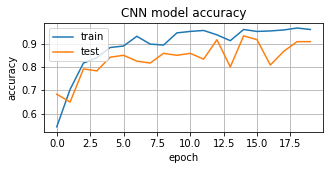

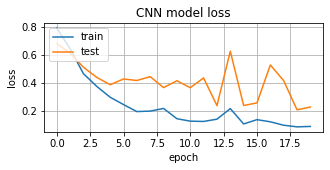

In [12]:
plt.figure(figsize=FIG_SIZE)
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=FIG_SIZE)
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### 7. Transfer Learning Using ResNet50

#### 7.1 Download Pretrained Model

In [13]:
from tensorflow.keras.applications import ResNet50

base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=2,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input

94781440/94765736 [==============================] - 0s 0us/step


#### 7.2 Create Model, Compile, and Train

In [14]:
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

In [15]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [16]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 416, 416, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                131136    
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23,723,138
Trainable params: 135,426
Non

In [17]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data = valid_data
)

Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 1.7780 - accuracy: 0.4958 - val_loss: 0.9154 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 8s 1s/step - loss: 0.7862 - accuracy: 0.5250 - val_loss: 0.6243 - val_accuracy: 0.6917
Epoch 3/20
8/8 [==============================] - 8s 1s/step - loss: 0.6417 - accuracy: 0.6167 - val_loss: 0.6027 - val_accuracy: 0.6417
Epoch 4/20
8/8 [==============================] - 9s 1s/step - loss: 0.5658 - accuracy: 0.6896 - val_loss: 0.5138 - val_accuracy: 0.7667
Epoch 5/20
8/8 [==============================] - 8s 1s/step - loss: 0.4789 - accuracy: 0.7896 - val_loss: 0.4977 - val_accuracy: 0.7667
Epoch 6/20
8/8 [==============================] - 8s 1s/step - loss: 0.4578 - accuracy: 0.7812 - val_loss: 0.4618 - val_accuracy: 0.7917
Epoch 7/20
8/8 [==============================] - 8s 1s/step - loss: 0.4457 - accuracy: 0.7958 - val_loss: 0.4362 - val_accuracy: 0.7917
Epoch 8/20
8/8 [========================

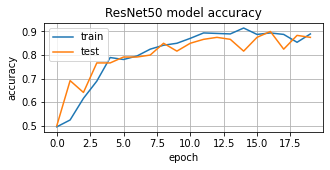

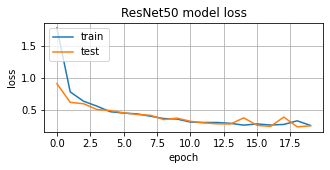

In [18]:
plt.figure(figsize=FIG_SIZE)
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(5,2))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### 8. Model Testing

In [19]:
train_data.class_indices

{'monas': 0, 'prambanan': 1}

Saving 2869470274.jpg to 2869470274.jpg
2869470274.jpg
monas


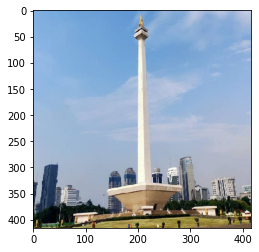

In [20]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = cnn_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)
  
  print(fn)
  if classes==0:
    print('monas')
  elif classes==1:
    print('prambanan')
  else:
    print("not found")

## 9. Model Evaluation

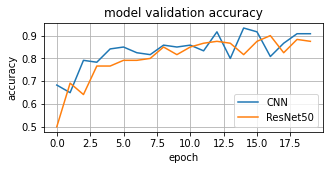

In [21]:
plt.figure(figsize=FIG_SIZE)
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'ResNet50'], loc='lower right')
plt.grid(True)
plt.show()

## 10. Model deployment

In [22]:
cnn_model.save('drive/MyDrive/place-prediction-cnn.h5')

In [23]:
resnet_model.save('drive/MyDrive/place-prediction-resnet.h5')